In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import rasterio as rio
from tslearn.utils import to_time_series_dataset, to_time_series
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import gzip
import numpy as np

directory = os.getcwd()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Clustering par parcelle

In [68]:
def clustering_par_parcelle(parcname, nb_classe, resultats_clustering_par_parcelle, save):

    list_files = []
    for image_name in os.listdir(f"{directory}/donnees/NDVI parcelle new"):
        if parcname[0] in image_name and parcname[1] in image_name : 
            list_files.append(image_name)

    donnees_pixel = pd.DataFrame({'date':'ini', 'ndvi':[1.1], 'x':[1], 'y':[1]})
    donnees_pixel['date'] = donnees_pixel['date'].astype('string')
    for image_name in list_files : 
        matrice_pixels = rio.open(f"{directory}/donnees/NDVI parcelle new/{image_name}").read(1)
        for i in range(matrice_pixels.shape[0]):
            for j in range(matrice_pixels.shape[1]):
                if matrice_pixels[i,j] > -1000000:
                    donnees_pixel = pd.concat([donnees_pixel, pd.DataFrame({'date':image_name[6:10] + '-' + image_name[10:12] + '-' +image_name[12:14], 'ndvi':matrice_pixels[i,j], 'x':[i], 'y':[j]})], axis=0)
    donnees_pixel = donnees_pixel.iloc[1:]

    shapeX = rio.open(f"{directory}/donnees/NDVI parcelle new/{list_files[0]}").read(1).shape[0]
    shapeY = rio.open(f"{directory}/donnees/NDVI parcelle new/{list_files[0]}").read(1).shape[1]

    donnees_pixel['date'] = donnees_pixel['date'].apply(date2doy)

    donnees_pixel = donnees_pixel.astype({"x": str,"y":str})
    donnees_pixel['id'] = donnees_pixel['x'] + '.'+ donnees_pixel['y']

    donnees_pixel = donnees_pixel.sort_values(["id",'date'])

    # Stockage des données ndvi et leur index en jour de l'année associé dans une liste de liste 
    id_list = donnees_pixel["id"].drop_duplicates().values.tolist()
    groups = donnees_pixel.groupby(['id'])
    pixel_list = []
    for name in id_list :  # Pour chaque id, on crée 2 listes : 1 liste des dates, 1 liste des ndvi correspondant aux dates
        pixel_list.append([name,groups.get_group(name)['date'].values.tolist(),groups.get_group(name)['ndvi'].values.tolist()])
    
    # On identifie les positions = NA dans les séries
    pixel_list_NA = []
    first_date = min([pix[1][0] for pix in pixel_list])
    last_date = max([pix[1][-1] for pix in pixel_list])
    
    for pix in pixel_list :
        indice = []
        val = []
        ind2 = 0
        # for i in range(first_date,last_date) : 
        for i in range(pix[1][0],pix[1][-1]):
            if i in pix[1]:
                indice.append(i)
                val.append(pix[2][ind2])
                ind2 += 1
            else : 
                indice.append(i)
                val.append(np.nan)
        pixel_list_NA.append([pix[0],indice,val])

    #Interpolation
    donnees_pixel_doy_na = []
    for pix in pixel_list_NA : 
        donnees_pixel_doy_na.append(pd.DataFrame(index=pix[1]))
        donnees_pixel_doy_na[-1]["ndvi"] = pix[2]

    donnees_pixel_doy_inter = [ k.interpolate() for k in donnees_pixel_doy_na]
    ndvi_inter = [k['ndvi'].values.tolist() for k in donnees_pixel_doy_inter]

    # CLustering
    X_inter = to_time_series_dataset(ndvi_inter)
    model = TimeSeriesKMeans(n_clusters=nb_classe, metric="dtw")
    model.fit(X_inter)

    #Récuperation des résultats du clustering 
    clusters = model.labels_.tolist()
    resultats_clustering_par_parcelle.append([ [parcname[0]+'.'+parcname[1], int(a.split('.')[0]), int(a.split('.')[1]), b] for a,b in zip(id_list,clusters)])

    if len(save) > 0: 
        # Création de l'image de la parcelle
        image_clustering = np.full((shapeX, shapeY), -1, dtype=int)
        # print(len(resultats_clustering_par_parcelle))
        # print(resultats_clustering_par_parcelle)
        for pix in resultats_clustering_par_parcelle[-1] : 
            image_clustering[pix[1],pix[2]] = pix[3]

        im = plt.imshow(image_clustering)
        values = range(nb_classe)
        colors = [ im.cmap(im.norm(value)) for value in values]
        # create a patch (proxy artist) for every color 
        patches = [ mpatches.Patch(color=colors[i], label="Classe {l}".format(l=values[i]) ) for i in range(len(values)) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.title(parcname[0]+' '+parcname[1])
        plt.savefig(f"{directory}/donnees/"+save+parcname[0]+parcname[1]+'graphe', bbox_inches='tight')
        # plt.show()
        plt.close()

        #Création de la courbe moyenne pour chaque classe
        cluster_group = [ [] for k in range(nb_classe)]
        for r,p in zip(resultats_clustering_par_parcelle[-1],donnees_pixel_doy_inter) :
            cluster_group[r[3]].append(p) 

        grp_means = []
        ind = cluster_group[0][0].index.tolist()
        duree = len(cluster_group[0][0]) 

        for grp in cluster_group:
            means = [0]* duree
            for pix in grp :
                ndvi_list = pix['ndvi'].tolist()
                for k in range(duree) : 
                    means[k] = means[k] + ndvi_list[k]/len(grp)
            grp_means.append(pd.DataFrame(means,index=ind))
        for k in range (nb_classe) : 
            plt.plot(grp_means[k],label = 'Classe ' + str(k))
        plt.legend()
        plt.title(parcname[0]+' '+parcname[1])
        plt.xlabel('Date')
        plt.ylabel('NDVI')
        plt.savefig(f"{directory}/donnees/"+save+parcname[0]+parcname[1]+'courbe', bbox_inches='tight')
        # plt.show()
        plt.close()


def date2doy(date): 
    nbday2022 = [31,28,31,30,31,30,31,31,30,31,30,31]
    nbday2020 = [31,29,31,30,31,30,31,31,30,31,30,31]
    month = int(date[5:7])
    day = int(date[8:10])
    if int(date[:4]) == 2020 : 
        nbday = nbday2020
    else : 
        nbday = nbday2022
    return sum(nbday[:month-1])+day



## 1ère étape : clustering à 2 classes --> identifier les bords

In [78]:
# Cette cellule réalise le clustering par parcellle à 2 clusters et sauvegarde les images et graphe dans un dossier

nb_cluster = 2
resultats_clustering_bords = []
save = "resultats_clustering_par_parcelle/images_bords/"

parc_name = [ image_name[19:-12]+image_name[6:10]  for image_name in os.listdir(f"{directory}/donnees/NDVI parcelle new")]
parc_name = [*set(parc_name)] #drop duplicate
parc_name.sort()
parc_name = [ [parc[:-4],parc[-4:]] for parc in parc_name]

cpt = 50
for parc in parc_name[50:]:
    print("cpt : ",cpt)
    cpt += 1
    # if not str(parc[0]+'.'+parc[1]) in [x[0][0] for x in resultats_clustering_bords]:
    clustering_par_parcelle(parc, nb_cluster, resultats_clustering_bords, save)

cpt :  50
cpt :  51


IndexError: list index out of range

In [77]:
# Save le fichier de clustering
# Fichier sans les séries

# for i in parc_name[34:]:
#     print(i)

parc_name[50]

# Parcelles avec prob : 1Fonteneilles.2022, 208gers2020.2020, 20Saison.2022, 2Saison.2022

['3822', '2022']

## 2ème étape : supprimer les bords des images

In [3]:
# Load le fichier resultats_clustering_bords
# Charger les matrices ndvi_all_parcelle, id_all_parcelle, shape_all_parcelle
f = gzip.GzipFile(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle.npy.gz", "r")
resultats_clustering_bords = np.load(f, allow_pickle=True)
resultats_clustering_bords = [x for x in resultats_clustering_bords]


In [10]:
resultats_clustering_bords[0]

[['0222.2022',
  '0',
  '13',
  1,
  [5320.55029296875,
   5532.482282366072,
   5744.414271763393,
   5956.346261160714,
   6168.278250558035,
   6380.210239955357,
   6592.142229352678,
   6804.07421875,
   6602.015625,
   6472.70546875,
   6343.3953125,
   6214.08515625,
   6084.775,
   5955.46484375,
   6089.6845703125,
   6223.904296875,
   5804.40966796875,
   5384.9150390625,
   5933.25146484375,
   5493.25732421875]],
 ['0222.2022',
  '0',
  '14',
  1,
  [4475.6171875,
   4808.37646484375,
   5141.1357421875,
   5473.89501953125,
   5806.654296875,
   6139.41357421875,
   6472.1728515625,
   6804.93212890625,
   6443.02783203125,
   6290.94931640625,
   6138.87080078125,
   5986.79228515625,
   5834.71376953125,
   5682.63525390625,
   5631.754150390625,
   5580.873046875,
   4927.010986328125,
   4273.14892578125,
   4984.3056640625,
   5399.9423828125]],
 ['0222.2022',
  '0',
  '15',
  1,
  [5175.23681640625,
   5340.486746651785,
   5505.736676897322,
   5670.986607142857,
 

## 3ème étape : clustering à x classes sur les parcelles redécoupées

In [3]:
# Chargement du fichier ndvi_all_parcelle
f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/ndvi_all_parcelle.npy.gz", "r")
ndvi_all_parcelle = np.load(f, allow_pickle=True)
ndvi_all_parcelle = [x for x in ndvi_all_parcelle]

## 4ème étape : construction de clusters "généralisés" à toutes les parcelles

In [84]:
# On ajoute aux résultats du clustering les séries de ndvi de chaque pixel
# --> ça permettra de construire les clusters généralisés à l'ensemble des parcelles
cpt = 0
for i in range(len(resultats_clustering_par_parcelle)):
    for j in range(len(resultats_clustering_par_parcelle[i])):
        resultats_clustering_par_parcelle[i][j].append(ndvi_all_parcelle[cpt])
        cpt += 1

In [87]:
# Sauvegarde des résultats du clustering 
a = np.array(resultats_clustering_par_parcelle)
f = gzip.GzipFile(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle.npy.gz", "w")
np.save(file = f, arr = a)
f.close()

<ipython-input-87-ce401ab89fee>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(resultats_clustering_par_parcelle)


In [96]:
# Chargement du fichier resultats_clustering_par_parcelle
f = gzip.GzipFile(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle.npy.gz", "r")
resultats_clustering_par_parcelle = np.load(f, allow_pickle=True)
resultats_clustering_par_parcelle = [x for x in resultats_clustering_par_parcelle]

# Pour l'instant on a des cluster pour chaque parcelle
# Il faut réussir à faire correspondre le cluster x de telle parcelle au cluster y d'une autre parcelle
# Idées de métrique sur la courbe moyenne des pixels du cluster : aire sous la courbe, max atteint, écart-type
# --> écart type semble mieux marcher d'après les images/courbes observées

In [106]:
# Génération de clusters généralisés avec la méthode écart-type
# On définit arbitrairement les clusters suivant : 0 = écart-type le plus faible, 1 = écart type plus important, 2 = écart type le plus grand
# écart type = écart type de la courbe moyenne des pixels constituant le cluster
# Traitement des parcelles ayant seulement 2 clusters prédits : écartées pour le moment.
# Objectif : modifier resultats_clustering_par_parcelle pr ajouter un numéro à la suite de chaque liste = numéro du nouveau cluster
def mapping_new_cluster(ancien_cluster, std):
    if ancien_cluster == np.argmin(std):
        return 0
    elif ancien_cluster == np.argmax(std):
        return 2
    else:
        return 1

for parcelle in resultats_clustering_par_parcelle:
    clusters = [[], [], []]
    for pix in parcelle:
        clusters[pix[3]].append(pix[4])
    
    std = []
    for clus in clusters:
        std.append(np.std([sum(x)/len(clus) for x in zip(*clus)]))

    for pix in parcelle:
        pix.append(mapping_new_cluster(pix[3], std))


# Code pour créer un csv avec nom de la parcelle et num du cluster généralisé (commun à toutes les parcelles) basé sur l'écart type de la courbe moyenne
list_to_df = []

for parcelle in resultats_clustering_par_parcelle:
    for pix in parcelle:
        list_to_df.append([pix[0],pix[1],pix[2],pix[5]])

df = pd.DataFrame(list_to_df, columns = ['parcelle','x','y','cluster_generalise'])
df
df.to_csv(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle_cluster_generalise.csv")


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
len(ndvi_all_parcelle)

72180

# Clustering sur toutes les parcelles en même temps

In [ ]:
def create_ndvi_allparcelle():

    parc_name = [ image_name[19:-12]+image_name[6:10]  for image_name in os.listdir(f"{directory}/donnees/NDVI parcelle new")]
    parc_name = [*set(parc_name)] #drop duplicate
    parc_name.sort()
    parc_name = [ [parc[:-4],parc[-4:]] for parc in parc_name]

    ndvi_all_parcelle = []
    id_all_parcelle = []
    shape_all_parcelle = []

    cpt = 0
    for parc in parc_name: 
        print("parcelle : ",cpt)
        cpt += 1
        list_files = []
        for image_name in os.listdir(f"{directory}/donnees/NDVI parcelle new"):
            if parc[0] in image_name and parc[1] in image_name : 
                list_files.append(image_name)

        donnees_pixel = pd.DataFrame({'date':'ini', 'ndvi':[1.1], 'x':[1], 'y':[1], 'nom_parc':f"{parc[0]}.{parc[1]}"})
        donnees_pixel['date'] = donnees_pixel['date'].astype('string')
        for image_name in list_files : 
            matrice_pixels = rio.open(f"{directory}/donnees/NDVI parcelle new/{image_name}").read(1)
            for i in range(matrice_pixels.shape[0]):
                for j in range(matrice_pixels.shape[1]):
                    if matrice_pixels[i,j] > -1000000:
                        donnees_pixel = pd.concat([donnees_pixel, pd.DataFrame({'date':image_name[6:10] + '-' + image_name[10:12] + '-' +image_name[12:14], 'ndvi':matrice_pixels[i,j], 'x':[i], 'y':[j], 'nom_parc':f"{parc[0]}.{parc[1]}"})], axis=0)
        donnees_pixel = donnees_pixel.iloc[1:]

        shape_all_parcelle.append([f"{parc[0]}.{parc[1]}", rio.open(f"{directory}/donnees/NDVI parcelle new/{list_files[0]}").read(1).shape[0], rio.open(f"{directory}/donnees/NDVI parcelle new/{list_files[0]}").read(1).shape[1]])

        donnees_pixel['date'] = donnees_pixel['date'].apply(date2doy)

        donnees_pixel = donnees_pixel.astype({"x": str,"y":str})
        donnees_pixel['id'] = donnees_pixel['nom_parc'] + '.' + donnees_pixel['x'] + '.'+ donnees_pixel['y']

        donnees_pixel = donnees_pixel.sort_values(["id",'date'])

        # Stockage des données ndvi et leur index en jour de l'année associé dans une liste de liste 
        id_list = donnees_pixel["id"].drop_duplicates().values.tolist()

        groups = donnees_pixel.groupby(['id'])
        pixel_list = []
        for name in id_list : 
            pixel_list.append([name,groups.get_group(name)['date'].values.tolist(),groups.get_group(name)['ndvi'].values.tolist()])

        pixel_list_NA = []
        # first_date = min([pix[1][0] for pix in pixel_list])
        # last_date = max([pix[1][-1] for pix in pixel_list])

        # for pix in pixel_list : 
        #     indice = []
        #     val = []
        #     ind2 = 0
        #     for i in range(first_date,last_date+5,5) : 
        #         if i in pix[1]:
        #             indice.append(i)
        #             val.append(pix[2][ind2])
        #             ind2 += 1
        #         else : 
        #             indice.append(i)
        #             val.append(np.nan)
        #     pixel_list_NA.append([pix[0],indice,val])
        #     id_all_parcelle.append(pix[0])
            
        for pix in pixel_list :
            indice = []
            val = []
            ind2 = 0
            # for i in range(first_date,last_date) : 
            for i in range(pix[1][0],pix[1][-1]):
                if i in pix[1]:
                    indice.append(i)
                    val.append(pix[2][ind2])
                    ind2 += 1
                else : 
                    indice.append(i)
                    val.append(np.nan)
            pixel_list_NA.append([pix[0],indice,val])
            id_all_parcelle.append(pix[0])

        # print(len([pixel_list_NA[i][0] for i in range(len(pixel_list_NA))]))

        #Interpolation
        donnees_pixel_doy_na = []
        for pix in pixel_list_NA : 
            donnees_pixel_doy_na.append(pd.DataFrame(index=pix[1]))
            donnees_pixel_doy_na[-1]["ndvi"] = pix[2]

        donnees_pixel_doy_inter = [ k.interpolate() for k in donnees_pixel_doy_na]
        # ndvi_inter = [k['ndvi'].values.tolist() for k in donnees_pixel_doy_inter]

        for k in donnees_pixel_doy_inter:
            ndvi_all_parcelle.append(k['ndvi'].values.tolist())

    return ndvi_all_parcelle, id_all_parcelle, shape_all_parcelle


def date2doy(date): 
    nbday2022 = [31,28,31,30,31,30,31,31,30,31,30,31]
    nbday2020 = [31,29,31,30,31,30,31,31,30,31,30,31]
    month = int(date[5:7])
    day = int(date[8:10])
    if int(date[:4]) == 2020 : 
        nbday = nbday2020
    else : 
        nbday = nbday2022
    return sum(nbday[:month-1])+day


ndvi_all_parcelle, id_all_parcelle, shape_all_parcelle = create_ndvi_allparcelle()


In [171]:
# Save les matrices de pixels ndvi_all_parcelle, id_all_parcelle, shape_all_parcelle
import gzip
import numpy

f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/ndvi_all_parcelle2.npy.gz", "w")
numpy.save(file = f, arr = ndvi_all_parcelle)
f.close()

f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/id_all_parcelle2.npy.gz", "w")
numpy.save(file = f, arr = id_all_parcelle)
f.close()

f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/shape_all_parcelle2.npy.gz", "w")
numpy.save(file = f, arr = shape_all_parcelle)
f.close()

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [63]:
# Charger les matrices ndvi_all_parcelle, id_all_parcelle, shape_all_parcelle
f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/ndvi_all_parcelle.npy.gz", "r")
ndvi_all_parcelle = np.load(f, allow_pickle=True)
ndvi_all_parcelle = [x for x in ndvi_all_parcelle]

f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/id_all_parcelle.npy.gz", "r")
id_all_parcelle = np.load(f, allow_pickle=True)
id_all_parcelle = [x for x in id_all_parcelle]

f = gzip.GzipFile(f"{directory}/donnees/resultats_pixel_all_parcelle/shape_all_parcelle.npy.gz", "r")
shape_all_parcelle = np.load(f, allow_pickle=True)
shape_all_parcelle = [[x[0],x[1],x[2]] for x in shape_all_parcelle]

In [174]:
# X_inter = to_time_series_dataset(ndvi_all_parcelle)

# index_commence_par_nan = [i for i in range(len(X_inter)) if np.isnan(X_inter[i][0])]
# index_commence_par_nan

# index_finit_par_nan = [i for i in index_commence_par_nan if np.isnan(X_inter[i][len(X_inter[i])-1])]
# index_finit_par_nan

# index_tout_nan = []
# a = []
# for x in X_inter[index_finit_par_nan]:
#     cpt = True
#     for i in range(len(x)):
#         a=x[i]
#         if not np.isnan(x[i]):
#             cpt = False
#             break
#     if cpt:
#         index_tout_nan.append(i)



[]

In [175]:
nb_classe = 2

# CLustering
X_inter = to_time_series_dataset(ndvi_all_parcelle)
model = TimeSeriesKMeans(n_clusters = 2, metric = "dtw", n_init = 3)
model.fit(X_inter)

clusters = model.labels_.tolist()
result_clustering = [ [str(id.split('.')[0])+'.'+str(id.split('.')[1]),int(id.split('.')[2]),int(id.split('.')[3]),num_cluster] for id,num_cluster in zip(id_all_parcelle,clusters)]

KeyboardInterrupt: 

In [ ]:
result_clustering[0]

In [ ]:
# Sauvegarder les résultats du clustering

# resultats_clustering_par_parcelle = pd.DataFrame(resultats_clustering_par_parcelle, columns = ['x','y','parcelle','serie','cluster_generalise'])

# resultats_clustering.to_csv(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle_cluster_generalise.csv")

# list_to_df = []

# for parcelle in resultats_clustering_par_parcelle:
#     for pix in parcelle:
#         list_to_df.append([pix[3],pix[5]])

# df = pd.DataFrame(list_to_df, columns = ['parcelle','cluster_generalise'])
# df
# df.to_csv(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle_cluster_generalise.csv")

In [31]:
# Chargement du fichier de clustering
df = pd.read_csv(f"{directory}/donnees/resultats_clustering.csv")
df = df.values.tolist()
result_clustering = [[x[1], x[2], x[3],x[4]] for x in df]
result_clustering[0]

['0222.2022', 0, 13, 2]

In [49]:
def afficher_image_et_graphe(nom_parc):

    # Image 
    image_clustering = np.full((int([parc[1] for parc in shape_all_parcelle if parc[0] == nom_parc][0]), int([parc[2] for parc in shape_all_parcelle if parc[0] == nom_parc][0])), -1, dtype=int)
    result_clustering_tmp = [pix for pix in result_clustering if pix[0] == nom_parc]
    for pix in result_clustering_tmp:
        image_clustering[pix[1],pix[2]] = pix[3]

    im = plt.imshow(image_clustering)
    values = range(nb_classe)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="Classe {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.title(nom_parc)
    # plt.savefig(f"{directory}/donnees/images/"+forname[0]+forname[1]+str(nb_classe)+'graphe', bbox_inches='tight')
    plt.show()
    plt.close()

    #Création de la courbe moyenne pour chaque classe
    cluster_group = [ [] for k in range(nb_classe)]
    ind_parc = [ind for ind,val in enumerate(id_all_parcelle) if val.split('.')[0]+'.'+val.split('.')[1] == nom_parc]
    ndvi_all_parcelle_tmp = [val for ind,val in enumerate(ndvi_all_parcelle) if ind in ind_parc]

    for r,p in zip(result_clustering_tmp,ndvi_all_parcelle_tmp) :
        cluster_group[r[3]].append(p) 

    grp_means = []
    df = pd.DataFrame({'fake':[i for i in range(0,5*len(cluster_group[0][0]) ,5)]}).set_index('fake')
    ind = df.index.to_list()
    # ind = cluster_group[0][0].index.tolist()
    duree = len(cluster_group[0][0]) 

    for grp in cluster_group:
        means = [0]* duree
        for pix in grp :
            # ndvi_list = pix['ndvi'].tolist()
            # if len(pix) < 20:
                # print("len pix",pix)
                # print("llen means",len(means))
                # print("duree",duree)
            for k in range(duree) : 
                means[k] = means[k] + pix[k]/len(grp)
        grp_means.append(pd.DataFrame(means,index=ind))
    for k in range (nb_classe) : 
        plt.plot(grp_means[k],label = 'Classe ' + str(k))
    plt.legend()
    plt.title(nom_parc)
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    # plt.savefig(f"{directory}/donnees/images/"+forname[0]+forname[1]+str(nb_classe)+'courbe', bbox_inches='tight')
    plt.show()
    plt.close()



1722.2022


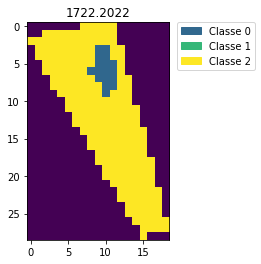

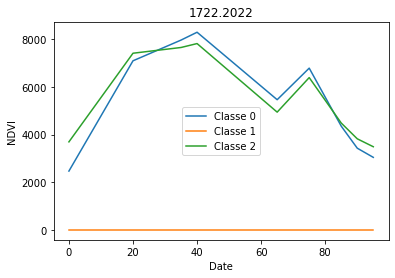

177gers2020.2020


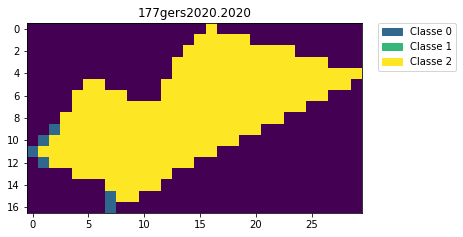

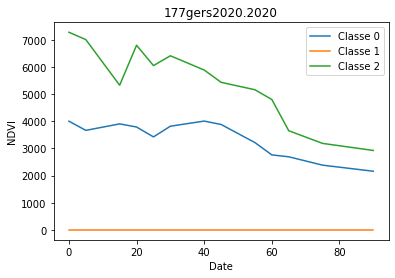

178gers2020.2020


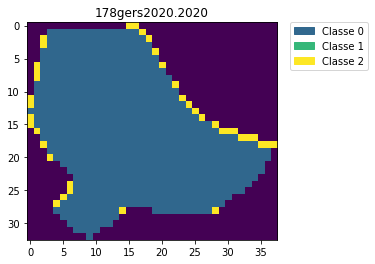

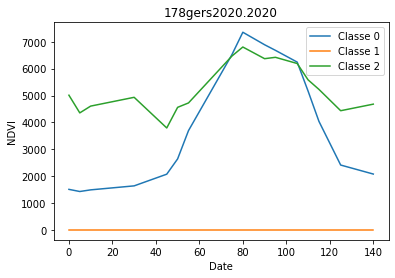

17Douaie.2022


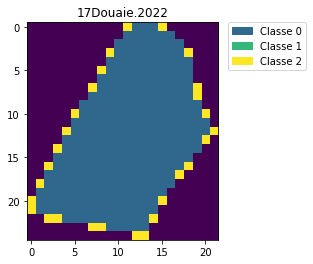

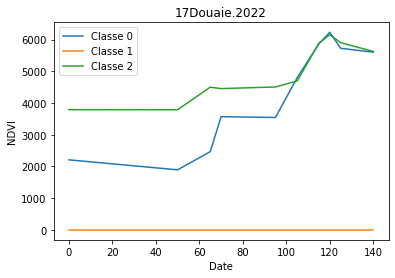

181gers2020.2020


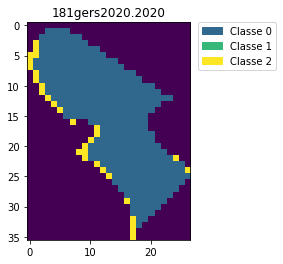

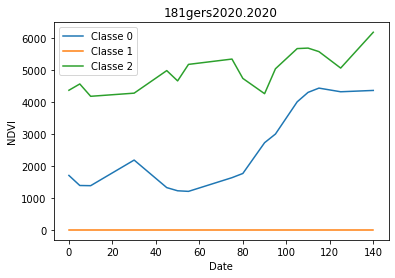

182gers2020.2020


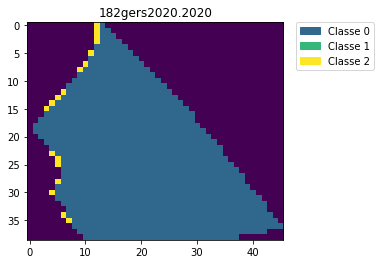

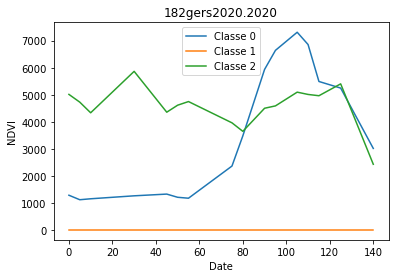

183gers2020.2020


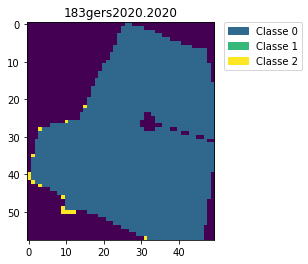

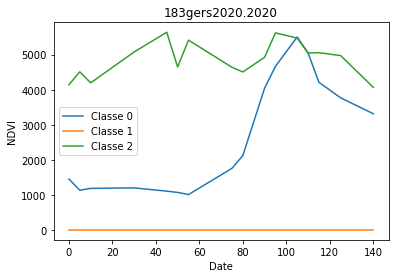

184gers2020.2020


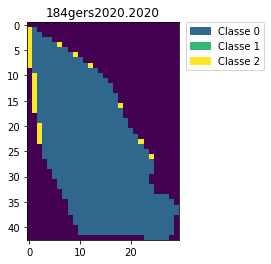

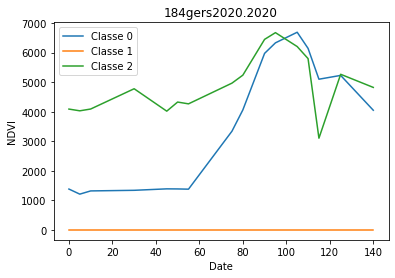

185gers2020.2020


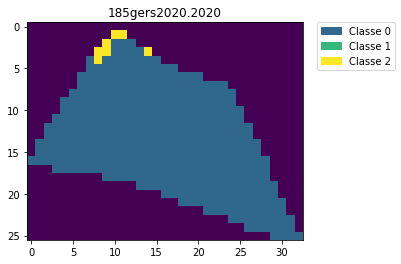

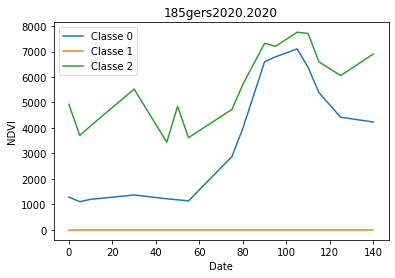

186gers2020.2020


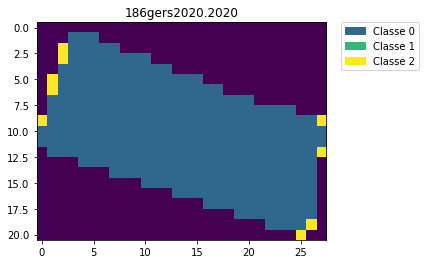

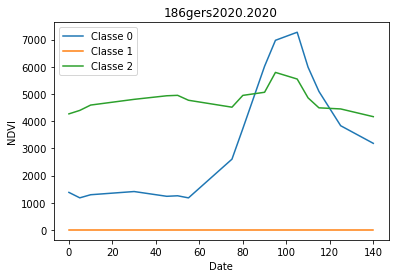

In [50]:
parc_name = [ image_name[19:-12]+image_name[6:10]  for image_name in os.listdir(f"{directory}/donnees/NDVI parcelle new")]
parc_name = [*set(parc_name)] #drop duplicate
parc_name.sort()
parc_name = [ [parc[:-4],parc[-4:]] for parc in parc_name]
parc_name = [parc[0]+'.'+parc[1] for parc in parc_name]
parc_name

nb_classe = 3

for parc in parc_name[10:20]:
    print(parc)
    afficher_image_et_graphe(parc)
